In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import neattext.functions as ntf
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
from scipy.special import softmax
import csv
import urllib.request

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_cleaned = pd.read_csv("../Data/cleaded_data.csv")
df_cleaned.head()

,date,username,like_count,retweet_count,processed_content
0,2023-03-29,RealProfitPros,0.0,0.0,"free ai marketing automation tools, strategies..."
1,2023-03-29,AmyLouWho321,0.0,0.0,chat gpt says 15. :face_with_tears_of_joy:
2,2023-03-29,yjleon1976,0.0,0.0,- chat pdf! check new ai quickly answers quest...
3,2023-03-29,ChatGPT_Thinks,0.0,0.0,"ai muses: ""in court life, face judge destiny j..."
4,2023-03-29,cordydbarb,0.0,0.0,no! chat gpt putting amazing recipes :tired_fa...


In [3]:
df_sorted = df_cleaned.sort_values(by='like_count', ascending=False)
df_top_10000 = df_sorted.iloc[:10000]
df_top_10000.reset_index(inplace=True, drop=True)

### Sentiment Analysis using Hugging Face

In [4]:
task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

# download label mapping
labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

# Pretrained
model = AutoModelForSequenceClassification.from_pretrained(MODEL)


text = "Good night"
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)
scores = output[0][0].detach().numpy()
scores = softmax(scores)

ranking = np.argsort(scores)
ranking = ranking[::-1]
for i in range(scores.shape[0]):
    l = labels[ranking[i]]
    s = scores[ranking[i]]
    print(f"{i+1}) {l} {np.round(float(s), 4)}")


1) positive 0.5896
2) neutral 0.3751
3) negative 0.0353


### Sentiment Analysis on Top 10,000 Tweets

In [7]:
negative = []
neutral  = []
positive = []

for i in range(len(df_top_10000)):
    encoded_input = tokenizer(df_top_10000.processed_content[i], return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    
    negative.append(scores[0])
    neutral.append(scores[1])
    positive.append(scores[2])
    
    if i%1000 == 0:
        print(str(i)+" completed")

0 completed
1000 completed
2000 completed
3000 completed
4000 completed
5000 completed
6000 completed
7000 completed
8000 completed
9000 completed


In [8]:
df_sentiment = df_top_10000.copy()

df_sentiment['negative'] = negative
df_sentiment['neutral'] = neutral
df_sentiment['positive'] = positive

In [9]:
df_sentiment.head()

,date,username,like_count,retweet_count,processed_content,negative,neutral,positive
0,2023-02-03,MoistCr1TiKaL,64094.0,2624.0,writing erotic prompts chat gpt hoping person ...,0.118656,0.819049,0.062295
1,2023-01-13,johnvianny,63835.0,16080.0,best ai tools need know chatgpt chatgpt3 artif...,0.045100,0.748205,0.206695
2,2023-03-06,rgay,44940.0,1349.0,pretty sure reading chat gpt student essay lik...,0.373744,0.549656,0.076601
3,2023-01-07,aaronsiim,42125.0,11501.0,ultra-modern generative ai:left_speech_bubble:...,0.031605,0.881386,0.087009
4,2023-01-12,kevinschawinski,38278.0,4160.0,chatgpt answer pause.,0.227726,0.693673,0.078601


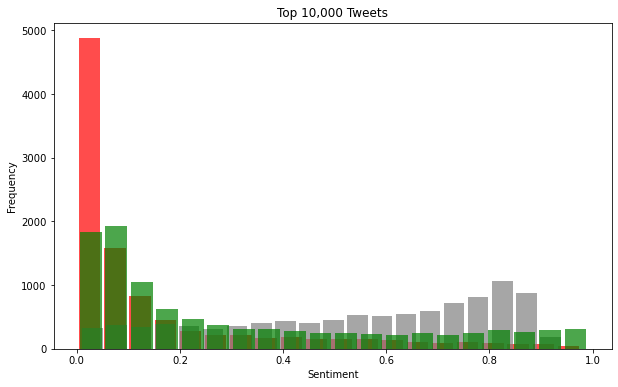

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(x=df_sentiment['negative'], bins=20, color='red',
                            alpha=0.7, rwidth=0.85)
n, bins, patches = plt.hist(x=df_sentiment['neutral'], bins=20, color='gray',
                            alpha=0.7, rwidth=0.85)
n, bins, patches = plt.hist(x=df_sentiment['positive'], bins=20, color='green',
                            alpha=0.7, rwidth=0.85)

plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.title('Top 10,000 Tweets')
maxfreq = n.max()


```diff
- Red is negative<br>
# Gray is neutral<br>
+ Green is positive
```

We can observe that majority of the tweets are neutral in emotion. <br>
Negative emotion is overall very less. The frequency close to 0 is very high for negative sentiment<br>
There's overall more positive emotion then negative 

### Sentiment Analysis on Topics created by LDA

In [11]:
Topics_topwords = {
    1 : ['chatgpt', 'asked', 'write', 'answer', 'question', 'ask', 'poem', 'love', 'style', 'explain', 'got', 'asking', 'gave', 'tell', 'friend'], 
    2 : ['chatgpt', 'student', 'use', 'better', 'bot', 'teacher', 'work', 'time', 'tool', 'btc', 'able', 'way', 'maybe', 'essay', 'help'], 
    3 : ['chatgpt', 'ai', 'google', 'model', 'new', 'openai', 'language', 'search', 'microsoft', 'tool', 'like', 'bing', 'chatbot', 'text', 'bard'], 
    4 : ['ai', 'chatgpt', 'technology', 'artificialintelligence', 'machinelearning', 'robot', 'tech', 'generativeai', 'python', 'openai', 'metaverse', 'innovation', 'art', 'tool', 'eye'], 
    5 : ['point', 'money', 'minute', 'skill', 'line', 'finally', 'challenge', 'productivity', 'play', 'error', 'sign', 'beginning', 'god', 'forward', 'funny'], 
    6 : ['chatgpt', 'ai', 'crypto', 'openai', 'rocket', 'token', 'know', 'blockchain', 'nft', 'launch', 'like', 'eth', 'robot', 'fire', 'today'], 
    7 : ['gpt', 'chat', 'like', 'people', 'know', 'thing', 'write', 'going', 'good', 'time', 'writing', 'tweet', 'actually', 'got', 'pretty'], 
    8 : ['chatgpt', 'bitcoin', 'plus', 'yet', 'buy', 'wan', 'cryptocurrency', 'yes', 'well', 'long', 'saying', 'testing', 'pay', 'article', 'crypto'], 
    9 : ['word', 'job', 'wrong', 'community', 'software', 'development', 'one', 'join', 'single', 'engineering', 'replaced', 'compared', 'engineer', 'safe', 'simply'], 
    10 : ['chatgpt', 'ai', 'think', 'human', 'intelligence', 'thought', 'future', 'paper', 'artificial', 'data', 'learning', 'world', 'user', 'new', 'said'], 
    11 : ['exam', 'extension', 'stuff', 'youtube', 'medical', 'personal', 'education', 'expert', 'chrome', 'edtech', 'clear', 'classroom', 'law', 'binance', 'explore'], 
    12 : ['chatgpt', 'prompt', 'use', 'code', 'free', 'app', 'link', 'fire', 'new', 'generate', 'content', 'build', 'video', 'case', 'api'], 
}

In [12]:
def assign_topic(text):
    
    words = text.split(' ')
    topic = 0
    match = 0
    for i in range(1,len(Topics_topwords)+1):
        count = 0
        for w in words:
            if w in Topics_topwords[i]:
                count+=1
        if count/len(words)>match:
            match = count/len(words)
            topic = i
    return topic, match

In [13]:
df_sentiment['Topic'] = 0
df_sentiment['Match'] = 0
for i in range(len(df_sentiment)):
    df_sentiment['Topic'][i], df_sentiment['Match'][i] = assign_topic(df_sentiment['processed_content'][i])

In [14]:
df_sentiment.head()

,date,username,like_count,retweet_count,processed_content,negative,neutral,positive,Topic,Match
0,2023-02-03,MoistCr1TiKaL,64094.0,2624.0,writing erotic prompts chat gpt hoping person ...,0.118656,0.819049,0.062295,7,0.333333
1,2023-01-13,johnvianny,63835.0,16080.0,best ai tools need know chatgpt chatgpt3 artif...,0.045100,0.748205,0.206695,4,0.444444
2,2023-03-06,rgay,44940.0,1349.0,pretty sure reading chat gpt student essay lik...,0.373744,0.549656,0.076601,7,0.333333
3,2023-01-07,aaronsiim,42125.0,11501.0,ultra-modern generative ai:left_speech_bubble:...,0.031605,0.881386,0.087009,1,0.020833
4,2023-01-12,kevinschawinski,38278.0,4160.0,chatgpt answer pause.,0.227726,0.693673,0.078601,1,0.666667


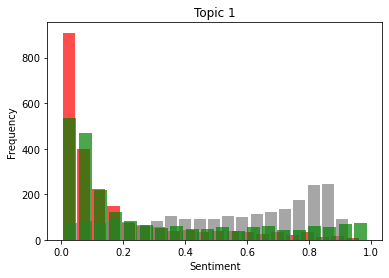

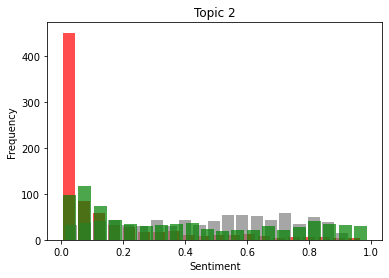

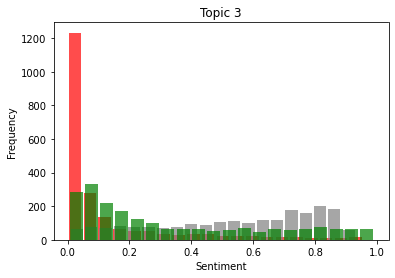

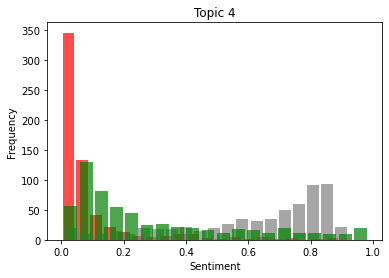

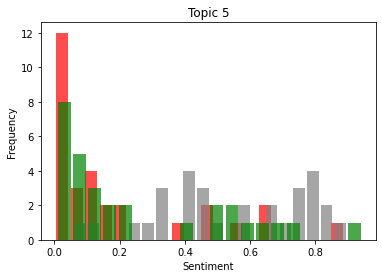

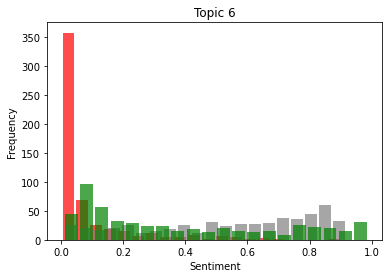

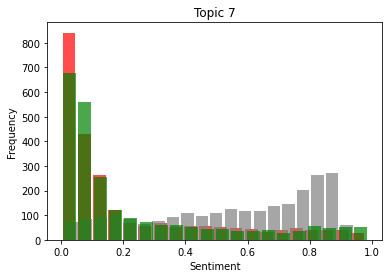

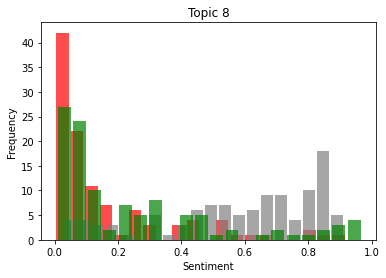

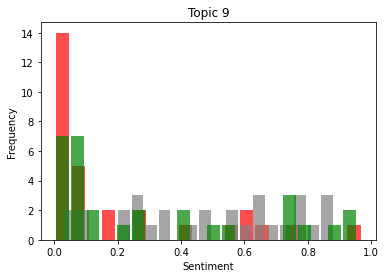

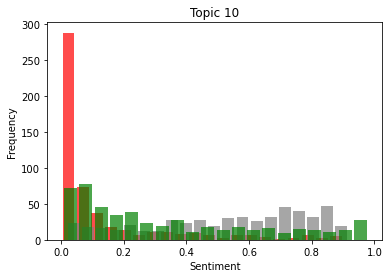

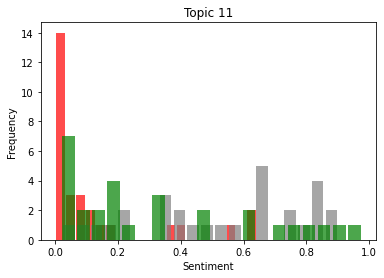

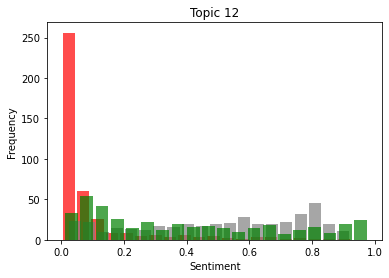

In [15]:
for t in range(1, len(Topics_topwords)+1):
    df_topic = df_sentiment[df_sentiment['Topic']==t] 
    # An "interface" to matplotlib.axes.Axes.hist() method
    n, bins, patches = plt.hist(x=df_topic['negative'], bins=20, color='red',
                                alpha=0.7, rwidth=0.85)
    n, bins, patches = plt.hist(x=df_topic['neutral'], bins=20, color='gray',
                                alpha=0.7, rwidth=0.85)
    n, bins, patches = plt.hist(x=df_topic['positive'], bins=20, color='green',
                                alpha=0.7, rwidth=0.85)

    plt.xlabel('Sentiment')
    plt.ylabel('Frequency')
    plt.title('Topic '+ str(t))
    maxfreq = n.max()
    plt.show()

We can observe that most topics are mostly neutral but some of them have more positive or negative sentiments compared to the complete distribution.

In [16]:
df_sentiment.Topic.value_counts()

Topic
7     2413
1     2245
3     2113
2      800
4      615
6      538
10     519
12     403
0      155
8      110
5       30
9       30
11      29
Name: count, dtype: int64

### Specific Topics and their overall sentiment

In [17]:
topics = ['ai', 'chatgpt', 'elonmusk', 'coding', 'google', 'exam', 'hate', 'love',
          'microsoft' ,'youtube', 'billgates', 'linkedin', 'resume', 'tesla']

df_sentiment['Topic_specific'] = ""
for topic in topics:
    df_sentiment.loc[df_sentiment['processed_content'].str.contains(topic), 'Topic_specific'] = topic


data = []
for topic in topics:
    topic_rows = df_sentiment[df_sentiment['Topic_specific'] == topic]
    
    # Average sentiment per topic
    negative = topic_rows['negative'].sum() / topic_rows.shape[0]
    neutral = topic_rows['neutral'].sum() / topic_rows.shape[0]
    positive = topic_rows['positive'].sum() / topic_rows.shape[0]
    
    sentiment = -negative + positive
 
    data.append({'Topic_specific': topic, 'negative': negative,'neutral': neutral, 'positive': positive, 'sentiment':sentiment})

df_sentiment_new = pd.DataFrame(data)

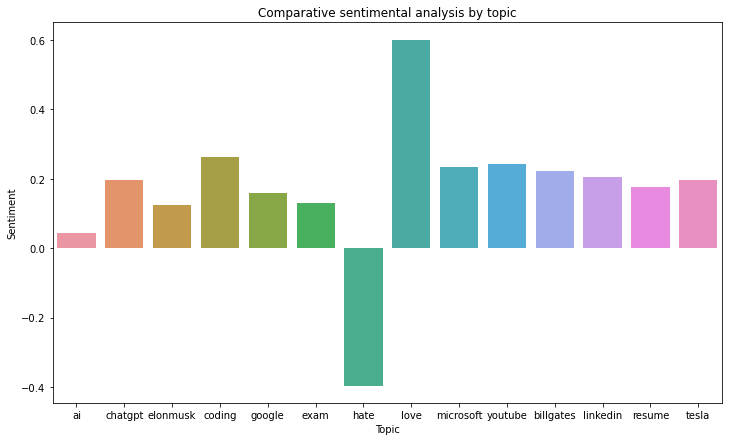

In [18]:
plt.figure(figsize=(12, 7))
sns.barplot(data=df_sentiment_new, x='Topic_specific', y='sentiment')#, palette=['#1DA1F2'])
plt.title('Comparative sentimental analysis by topic')
plt.xlabel('Topic')
plt.ylabel('Sentiment')
plt.show()